---
title: "Analyze generated dataset"
execute:
  echo: true
  enabled: false
  output: true
  warning: false
---

In [2]:
#| echo: false
#| output: false
basepath = "/home/u1/"

In [3]:
#| echo: false
#| output: false
import os
os.environ["MODIN_ENGINE"] = "dask"
import modin.pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)

In [4]:
from detect_common import *

## Multi-node experiment with FluBot and benign DoH

Traffic stored in `v5_1.csv` (B1) and `v5_2.csv` (B2) (@fig-timeline).

Let's convert it to feather for faster processing, and get a bird view on the data.

In [4]:
#| output: false

df = pd.read_csv(basepath + "datasets/flubot20230323/data/v5_1.csv")
df.to_feather("cached/v5_1.ft")
df = pd.read_csv(basepath + "datasets/flubot20230323/data/v5_2.csv")
df.to_feather("cached/v5_2.ft")

To remove this warning, run the following python code before doing dataframe operations:

    from distributed import Client

    client = Client()

2023-03-23 18:47:47,079 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-d5ei2zjm', purging
2023-03-23 18:47:47,079 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ktyevw26', purging
2023-03-23 18:47:47,079 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-uj9jhose', purging
Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


In [5]:
import dateutil.parser

df1 = pd.read_feather("cached/v5_1.ft")
df1["time TIME_FIRST"] = df1["time TIME_FIRST"].apply(dateutil.parser.parse)

To remove this warning, run the following python code before doing dataframe operations:

    from distributed import Client

    client = Client()

Perhaps you already have a cluster running?
Hosting the HTTP server on port 35069 instead


In [6]:
len(df1)

22640

In [7]:
df2 = pd.read_feather("cached/v5_2.ft")
df2["time TIME_FIRST"] = df2["time TIME_FIRST"].apply(dateutil.parser.parse)

In [8]:
len(df2)

181357

In [9]:
df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 181357 entries, 0 to 181356
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------------------------  ---------------  ----- 
 0   ipaddr DST_IP             181357 non-null  object
 1   ipaddr SRC_IP             181357 non-null  object
 2   uint64 BYTES              181357 non-null  int64
 3   uint64 BYTES_REV          181357 non-null  int64
 4   uint64 LINK_BIT_FIELD     181357 non-null  int64
 5   time TIME_FIRST           181357 non-null  object
 6   time TIME_LAST            181357 non-null  object
 7   macaddr DST_MAC           181357 non-null  object
 8   macaddr SRC_MAC           181357 non-null  object
 9   uint32 PACKETS            181357 non-null  int64
 10  uint32 PACKETS_REV        181357 non-null  int64
 11  uint16 DST_PORT           181357 non-null  int64
 12  uint16 SRC_PORT           181357 non-null  int64
 13  uint16 TLS_VERSION        181357 non-null  int64
 14  uint8 D

In [9]:
local_df1 = df1[df1["ipaddr SRC_IP"].str.startswith("192.168")]
local_df2 = df2[df2["ipaddr SRC_IP"].str.startswith("192.168")]
len(local_df1), len(local_df2)

(18218, 173067)

In [10]:
local_ips2 = local_df2["ipaddr SRC_IP"].unique().tolist()
local_ips2

['192.168.2.249',
 '192.168.2.149',
 '192.168.2.42',
 '192.168.2.217',
 '192.168.1.1']

In [11]:
local_ips1 = local_df1["ipaddr SRC_IP"].unique().tolist()
local_ips = list(set(local_ips1 + local_ips2))
local_ips

['192.168.2.42',
 '192.168.2.217',
 '192.168.1.1',
 '192.168.2.149',
 '192.168.2.249']

## B1 period vs B2 period

2023-03-23 18:48:32,737 - distributed.worker - ERROR - Exception during execution of task lambda-bd7d17bf2ff354e87907de314ba14b25.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: '_deploy_dask_func-907e0339-3824-4563-8621-8e9f81259b5a'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execu

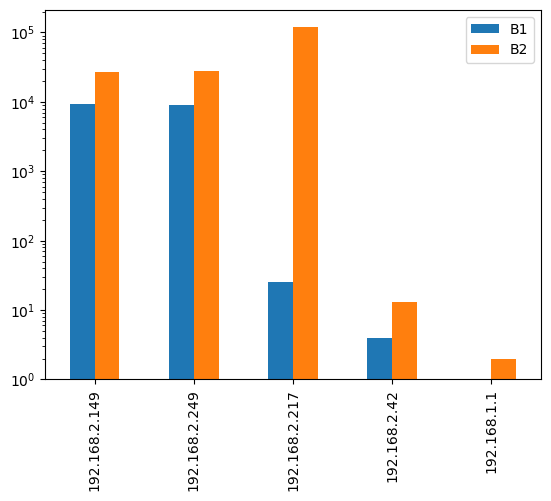

In [13]:
from matplotlib import pyplot as plt

d = {
    'B1': local_df1["ipaddr SRC_IP"].value_counts().to_dict(),
    'B2': local_df2["ipaddr SRC_IP"].value_counts().to_dict(),
}

pd.DataFrame(d).plot(kind='bar', log=True)
plt.show()

## Plaintext DNS vs whole HTTPS traffic

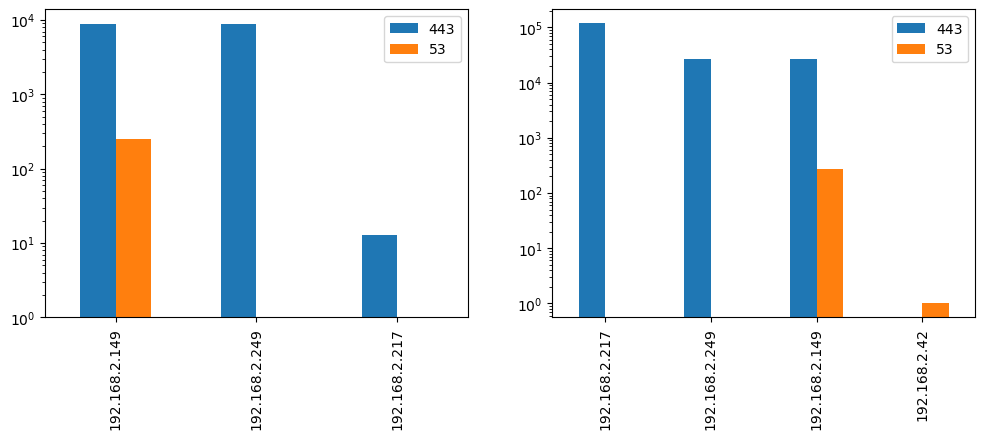

In [14]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

for ax, df in zip(axs, [local_df1, local_df2]):
    d = {
        '443': df[df["uint16 DST_PORT"] == 443]["ipaddr SRC_IP"].value_counts().to_dict(),
        '53': df[df["uint16 DST_PORT"] == 53]["ipaddr SRC_IP"].value_counts().to_dict(),
    }
    pd.DataFrame(d).plot(kind='bar', log=True, ax=ax)

plt.show()

## Timeline of the traffic

In [15]:
min_ts = local_df1["time TIME_FIRST"].min()
min_ts_b2 = local_df2["time TIME_FIRST"].min()
min_ts, min_ts_b2

(Timestamp('2023-03-23 14:07:18.810756'),
 Timestamp('2023-03-23 14:50:04.318641'))

In [16]:
f = '2min'

def plot_packets_by_port(local_df, host, dst_port):
    a1_t = local_df[local_df["ipaddr SRC_IP"] == host].set_index(["time TIME_FIRST"])

    a1_t53 = a1_t[a1_t["uint16 DST_PORT"] == dst_port][["uint32 PACKETS", "uint32 PACKETS_REV"]]
    a1_t53["PACKETS"] = a1_t53["uint32 PACKETS"] + a1_t53["uint32 PACKETS_REV"]
    df_resample = a1_t53.groupby(pd.Grouper(freq=f, origin=min_ts)).sum()
    return df_resample


In [17]:
local_df = pd.concat([local_df1, local_df2]).reset_index(drop=True)

2023-03-23 18:49:27,670 - distributed.worker - ERROR - Exception during execution of task lambda-487f7b4b5e8268aa82066021bb1dbfb1.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-c3843b23-4961-4695-aaa2-d69d61e279e2'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execution
  

In [18]:
df_plots = {h: plot_packets_by_port(local_df, h, 53) for h in local_ips}

2023-03-23 18:50:08,358 - distributed.worker - ERROR - Exception during execution of task lambda-a9d6036715dfaf2d9ee22108ad9201ea.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-d8a4d786-42f6-4bbd-bcbf-033d07da3f1c'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execution
  

[]

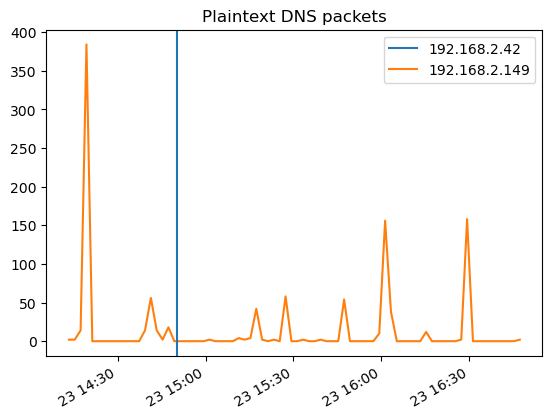

In [19]:
pd.DataFrame({
    h: df["PACKETS"].to_dict()
    for h, df in df_plots.items()
    if len(df) > 0
}).plot()

plt.axvline(x=min_ts_b2)

plt.title("Plaintext DNS packets")
plt.plot()

In [20]:
df_plots = {h: plot_packets_by_port(local_df, h, 443) for h in local_ips}

2023-03-23 18:51:59,134 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-23 18:52:06,001 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-23 18:52:09,630 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-23 18:52:12,053 - distributed.worker - ERROR - Exception during execution of task lambda-d044d457275fe9564bad805ce3884984.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-a7df739d-8adb-476d-93a6-dc9266b7d22

[]

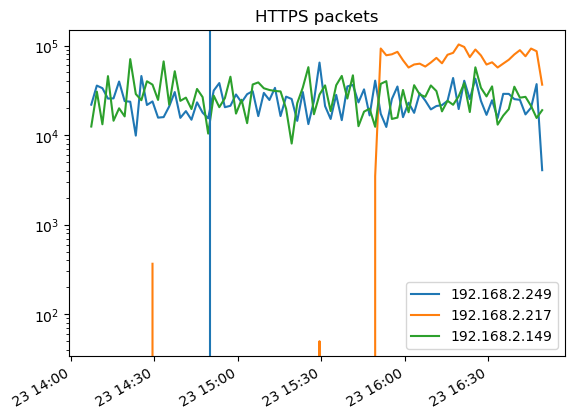

In [21]:
pd.DataFrame({
    h: df["PACKETS"].to_dict()
    for h, df in df_plots.items()
    if len(df) > 0
}).plot(logy=True)

plt.axvline(x=min_ts_b2)

plt.title("HTTPS packets")
plt.plot()

## Let's filter out the benign DoH traffic

In [10]:
dns_providers = [
    "dns.google",
    "cloudflare-dns.com",
    "dns.quad9.net",
    "adguard-dns.com",
    "doh.cleanbrowsing.org",
    "freedns.controld.com",
]

In [11]:
#| output: false
p1version = "v6"
p2version = "v7"
p3version = "v5"

In [12]:
df = pd.concat([
    pd.read_feather("cached/v5_1.ft"), pd.read_feather("cached/v5_2.ft")
])
some_doh = df[df["ipaddr SRC_IP"] == "192.168.2.149"]

In [15]:
def filter_doh(sni):
    if not sni:
        return False
    return any(pat in sni for pat in dns_providers)

some_doh_https = some_doh[some_doh["uint16 DST_PORT"] == 443]
doh_only = some_doh_https[some_doh_https["string TLS_SNI"].apply(filter_doh, axis=1)]
len(doh_only)

624

In [20]:
doh_ips = pd.DataFrame({"ip": doh_only["ipaddr DST_IP"].unique()})
doh_ips

,ip
0,104.16.249.249
1,104.16.248.249
2,94.140.14.141
3,94.140.14.140
4,185.228.168.168
5,8.8.8.8
6,8.8.4.4
7,149.112.112.112
8,76.76.2.11
9,185.228.168.10


In [21]:
doh_ips.to_csv(basepath + "datasets/flubot20230323/data/v5_benign_doh_ips.csv", index=False)
